This script setup the experiments, assuming that the l4s part has been installed correctly. 

In [7]:
import subprocess

tx0_prefix = "ssh PeterYao@pc490.emulab.net"
router0_prefix = "ssh PeterYao@pc500.emulab.net"
router1_prefix = "ssh PeterYao@pc487.emulab.net"
rx0_prefix = "ssh PeterYao@pc816.emulab.net"

nodes_prefix = [tx0_prefix, router0_prefix, router1_prefix, rx0_prefix]

class node:
    def __init__(self, node_ssh_prefix) -> None:
        self.ssh_prefix = node_ssh_prefix

    def execute(self, command, background=False):
        if background:
            print("executing in background")
            # full_command = f"{self.ssh_prefix} 'setsid nohup {command} > /dev/null 2>&1 &'"
            full_command = f'{self.ssh_prefix} "{command}"'
            subprocess.Popen(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        else:
            full_command = f'{self.ssh_prefix} "{command}"'
            result = subprocess.run(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if result.returncode == 0:
                print(result.stdout.decode('utf-8'))
            else:
                print(f"Error: {result.stderr.decode('utf-8')}")
        return None
        
tx0_node = node(tx0_prefix)
delay_node = node(router0_prefix)
router_node = node(router1_prefix)
rx0_node = node(rx0_prefix)

nodes = [tx0_node, delay_node, router_node, rx0_node]





In [31]:
from fabric import Connection


tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)




delay = Connection(
    host='pc500.emulab.net',
    user = 'PeterYao',
    port=22,
)


router = Connection(
    host='pc487.emulab.net',
    user='PeterYao',
    port=22,
)

rx = Connection(
    host='pc816.emulab.net',
    user
    = 'PeterYao',  
    port=22,
)

conns = [router, delay, tx, rx]


# Experiment 1 50-50 base thp and latency

In [14]:
commands_noecn = "bash -c 'sudo sysctl -w net.ipv4.tcp_congestion_control=cubic; sudo sysctl -w net.ipv4.tcp_ecn=0'"
for node in nodes:
    node.execute(commands_noecn)
    
print("validating...")
for node in nodes:
    node.execute("sudo sysctl net.ipv4.tcp_congestion_control")
    node.execute("sudo sysctl net.ipv4.tcp_ecn")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

validating...
net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0



In [4]:
# for some reason, this cannot be automated

for node in nodes:
    # Download and unzip the kernel package
    node.execute("wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip")
    node.execute("sudo apt install unzip")
    node.execute("unzip l4s-testing.zip")
    
    # Install the kernel packages and update GRUB
    node.execute("sudo dpkg --install debian_build/*")
    node.execute("sudo update-grub")
    node.execute("sudo reboot")

for node in nodes:
    # check kernel version
    node.execute("hostname; uname -a")


Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-26ubuntu3.2).
The following package was automatically installed and is no longer required:
  libbpf0
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.



In [ ]:
cmd_dualpi2="""sudo apt-get update
sudo apt -y install git gcc make bison flex libdb-dev libelf-dev pkg-config libbpf-dev libmnl-dev libcap-dev libatm1-dev selinux-utils libselinux1-dev
sudo git clone https://github.com/L4STeam/iproute2.git
cd iproute2
sudo chmod +x configure
sudo ./configure
sudo make
sudo make install"""

router.run(cmd_dualpi2)
router.run("sudo modprobe sch_dualpi2")

In [ ]:
packages = ['iperf3', 'net-tools', 'moreutils']
for conn in conns:
    for package in packages:
        conn.sudo(f'sudo apt update; apt-get -y install {package}')

In [3]:
offloads = ["gro", "lro", "gso", "tso"]

for conn in conns[:3]:
    for offload in offloads:
        conn.sudo(f'ethtool -K eth1 {offload} off')
        conn.sudo(f'ethtool -K eth2 {offload} off')
        



netlink error: no device matches name (offset 24)
netlink error: No such device


UnexpectedExit: Encountered a bad command exit code!

Command: "sudo -S -p '[sudo] password: ' ethtool -K eth2 gro off"

Exit code: 92

Stdout: already printed

Stderr: already printed



In [4]:
rx.sudo('ethtool -K vlan171 gro off')
rx.sudo('ethtool -K vlan171 lro off')
rx.sudo('ethtool -K vlan171 gso off')
rx.sudo('ethtool -K vlan171 tso off')

Cannot change large-receive-offload


<Result cmd="sudo -S -p '[sudo] password: ' ethtool -K vlan171 tso off" exited=0>

In [15]:
# modify the delay on the delay node
base_rtt = 25
delay_interfaces = ["enp5s0f0", "eno3"]

for e in delay_interfaces:
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=base_rtt/2)
    delay.run(cmds)

In [17]:
delay.run("sudo tc qdisc show dev enp5s0f0")
delay.run("sudo tc qdisc show dev eno3")

qdisc netem 8001: root refcnt 9 limit 60000 delay 12.5ms
qdisc netem 8002: root refcnt 9 limit 60000 delay 12.5ms


<Result cmd='sudo tc qdisc show dev eno3' exited=0>

In [66]:
# set up the btl node
n_bdp = 2
base_rtt = 25
btl_capacity = 100 #in Mbps

# fixed values
btl_limit    = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 
packet_number=int(btl_limit/1500)+1

print("btl limit: ", btl_limit)
print("packet number: ", packet_number)

btl limit:  625000
packet number:  417


In [8]:
from fabric import ThreadingGroup
from invoke.exceptions import UnexpectedExit

# Define hosts with respective ports
hosts = [
    'PeterYao@pc605.emulab.net:30042',
    'PeterYao@pc603.emulab.net:30042',
    'PeterYao@pc604.emulab.net:30042',
    'PeterYao@pc760.emulab.net:22',
]

# Initialize the ThreadingGroup
group = ThreadingGroup(*hosts)

commands = [
    "wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip",
    "sudo apt update && sudo apt install -y unzip",
    "unzip l4s-testing.zip",
    "sudo dpkg --install debian_build/*",
    "sudo update-grub",
    "sudo reboot"
]

with group as g:
    for cmd in commands:
        try:
            print(f"Executing: {cmd}")
            g.run(cmd, hide=False)
        except UnexpectedExit as e:
            print(f"Command failed: {cmd}\nError: {e}")

Executing: wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip


--2024-09-16 00:40:41--  https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... --2024-09-16 00:40:42--  https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... --2024-09-16 00:40:42--  https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/172778452/0854110e-90dc-44f0-830f-19c83ec8fe1b?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20240916%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20240916T064042Z&X-Amz

Executing: sudo apt update && sudo apt install -y unzip


Hit:1 http://repos.emulab.net/emulab/ubuntu jammy InRelease
Hit:2 http://repos.emulab.net/grub-backports/ubuntu jammy InRelease
Hit:1 http://repos.emulab.net/emulab/ubuntu jammy InRelease
Hit:1 http://repos.emulab.net/emulab/ubuntu jammy InRelease
Hit:2 http://repos.emulab.net/grub-backports/ubuntu jammy InRelease
Hit:2 http://repos.emulab.net/grub-backports/ubuntu jammy InRelease
Hit:1 https://apt.kitware.com/ubuntu bionic InRelease
Hit:3 http://us.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://download.docker.com/linux/ubuntu bionic InRelease
Hit:3 http://us.archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease
Get:4 http://us.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Err:1 https://apt.kitware.com/ubuntu bionic InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 1A127079A92F09ED
Get:4 http://us.archive.ubuntu.com/ubuntu jammy-updates In

106 packages can be upgraded. Run 'apt list --upgradable' to see them.


Reading package lists...


Building dependency tree...

Reading package lists...
Building dependency tree...
Reading state information...
106 packages can be upgraded. Run 'apt list --upgradable' to see them.



Reading state information...

Reading state information...


 does not have a stable CLI interface. Use with caution in scripts.

Reading package lists...


Building dependency tree...Suggested packages:
  zip

The following packages will be upgraded:
  unzip
1 upgraded, 0 newly installed, 0 to remove and 105 not upgraded.
Need to get 175 kB of archives.
After this operation, 1,024 B of additional disk space will be used.
Get:1 http://us.archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]
Reading state information...
Suggested packages:
  zip
The following packages will be upgraded:
  unzip
Suggested packages:
  zip
The following packages will be upgraded:
  unzip
1 upgraded, 0 newly installed, 0 to remove and 105 not upgraded.
Need to get 175 kB of archives.
After this operation, 1,024 B of additional disk space will be used.
Get:1 http://us.archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]

1 upgraded, 0 newly installed, 0 to remove and 105 not upgraded.
Need to get 175 kB of archives.
After this operation, 1,024 B of additional disk space will be used.
Get:1 http

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 175 kB in 0s (488 kB/s)

Reading state information...
349 packages can be upgraded. Run 'apt list --upgradable' to see them.


W: An error occurred during the signature verification. The repository is not updated and the previous index files will be used. GPG error: https://apt.kitware.com/ubuntu bionic InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 1A127079A92F09ED
W: Failed to fetch https://apt.kitware.com/ubuntu/dists/bionic/InRelease  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 1A127079A92F09ED
W: Some index files failed to download. They have been ignored, or old ones used instead.




Reading package lists...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Building dependency tree...

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Fetched 175 kB in 0s (405 kB/s)


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 175 kB in 0s (404 kB/s)
(Reading database ... 95638 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
(Reading database ... 95638 files and directories currently installed.)tabase ... 65%
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...

(Reading database ... 95638 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.2) over (6.0-26ubuntu3.1) ...
Unpacking unzip (6.0-26ubuntu3.2) over (6.0-26ubuntu3.1) ...

Reading state information...
Setting up unzip (6.0-26ubuntu3.2) ...
Setting up unzip (6.0-26ubuntu3.2) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
The following packages were automatically installed and are no longer required:
  libarchive13 libjsoncpp1 librhash0 libuv1
Use 'sudo apt autoremove' to remove them.
Setting up unzip (6.0-26ubuntu3.2) ...
The following packages will be

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 168 kB in 0s (411 kB/s)
(Reading database ... 150250 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.2_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.2) over (6.0-21ubuntu1.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Setting up unzip (6.0-21ubuntu1.2) ...
Processing triggers for man-db (2.8.3-2) ...
Executing: unzip l4s-testing.zip
Archive:  l4s-testing.zip
   creating: debian_build/
  inflating: debian_build/iproute2_5.10.0-1_amd64.deb  Archive:  l4s-testing.zip

  inflating: debian_build/linux-image-5.15.72-56eae305c-prague-91_1_amd64.deb     creating: debian_build/
  inflating: debian_build/iproute2_5.10.0-1_amd64.deb  
  inflating: debian_build/linux-image-5.15.72-56eae305c-prague-91_1_amd64.deb  Archive:  l4s-testing.zip
   creating: debian_build/
  inflating: debian_build/iproute2_5.10.0-1_amd64.deb  Archive:  l4s-testing.zip
   creating: debian_build/
  inflating: debian_build/iproute2_5.10.0-1_amd64.deb  
  inflati

dpkg: warning: downgrading iproute2 from 5.15.0-1ubuntu2 to 5.10.0-1


Selecting previously unselected package iproute2-doc.
Preparing to unpack .../iproute2-doc_5.10.0-1_all.deb ...
Unpacking iproute2-doc (5.10.0-1) ...
(Reading database ... 95638 files and directories currently installed.)
Preparing to unpack .../iproute2_5.10.0-1_amd64.deb ...
Selecting previously unselected package linux-headers-5.15.72-56eae305c-prague-91.
Preparing to unpack .../linux-headers-5.15.72-56eae305c-prague-91_1_amd64.deb ...
Unpacking linux-headers-5.15.72-56eae305c-prague-91 (1) ...
Unpacking iproute2 (5.10.0-1) over (5.15.0-1ubuntu2) ...


dpkg: warning: downgrading iproute2 from 5.15.0-1ubuntu2 to 5.10.0-1
dpkg: warning: downgrading iproute2 from 5.15.0-1ubuntu2 to 5.10.0-1


(Reading database ... 95638 files and directories currently installed.)
Preparing to unpack .../iproute2_5.10.0-1_amd64.deb ...
Unpacking iproute2 (5.10.0-1) over (5.15.0-1ubuntu2) ...
(Reading database ... 95638 files and directories currently installed.)
Preparing to unpack .../iproute2_5.10.0-1_amd64.deb ...
Unpacking iproute2 (5.10.0-1) over (5.15.0-1ubuntu2) ...
Selecting previously unselected package iproute2-doc.
Preparing to unpack .../iproute2-doc_5.10.0-1_all.deb ...
Unpacking iproute2-doc (5.10.0-1) ...
Selecting previously unselected package iproute2-doc.
Preparing to unpack .../iproute2-doc_5.10.0-1_all.deb ...
Unpacking iproute2-doc (5.10.0-1) ...
Selecting previously unselected package linux-headers-5.15.72-56eae305c-prague-91.
Preparing to unpack .../linux-headers-5.15.72-56eae305c-prague-91_1_amd64.deb ...
Unpacking linux-headers-5.15.72-56eae305c-prague-91 (1) ...
Selecting previously unselected package iproute2-doc.
Preparing to unpack .../iproute2-doc_5.10.0-1_all.d

dpkg: warning: downgrading linux-libc-dev:amd64 from 4.15.0-159.167 to 1


Preparing to unpack .../linux-libc-dev_1_amd64.deb ...
Unpacking linux-libc-dev:amd64 (1) over (4.15.0-159.167) ...


dpkg: dependency problems prevent configuration of iproute2:
 iproute2 depends on libc6 (>= 2.29); however:
  Version of libc6:amd64 on system is 2.27-3ubuntu1.2.

dpkg: error processing package iproute2 (--install):
 dependency problems - leaving unconfigured


Setting up iproute2-doc (5.10.0-1) ...
Setting up linux-headers-5.15.72-56eae305c-prague-91 (1) ...
Setting up linux-image-5.15.72-56eae305c-prague-91 (1) ...


Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/e1000e-dkms/3.4.2.3/build/make.log for more information.


Selecting previously unselected package linux-image-5.15.72-56eae305c-prague-91.
Preparing to unpack .../linux-image-5.15.72-56eae305c-prague-91_1_amd64.deb ...
Unpacking linux-image-5.15.72-56eae305c-prague-91 (1) ...
Selecting previously unselected package linux-image-5.15.72-56eae305c-prague-91.
Preparing to unpack .../linux-image-5.15.72-56eae305c-prague-91_1_amd64.deb ...
Unpacking linux-image-5.15.72-56eae305c-prague-91 (1) ...
Selecting previously unselected package linux-image-5.15.72-56eae305c-prague-91.
Preparing to unpack .../linux-image-5.15.72-56eae305c-prague-91_1_amd64.deb ...
Unpacking linux-image-5.15.72-56eae305c-prague-91 (1) ...


Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/i40e-dkms/2.7.29/build/make.log for more information.
Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/i40evf-dkms/3.6.15/build/make.log for more information.
Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/igb-dkms/5.3.5.22/build/make.log for more information.
Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/ixgbe-dkms/5.5.3/build/make.log for more information.
Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/ixgbevf-dkms/4.5.2/build/make.log for more information.
Error! Bad return status for module build on kernel: 5.15.72-56eae305c-prague-91 (x86_64)
Consult /var/lib/dkms/mpt3sas-dkms/26.00.00.00/build/make.log for more info

Preparing to unpack .../linux-libc-dev_1_amd64.deb ...
Unpacking linux-libc-dev:amd64 (1) over (5.15.0-113.123) ...


dpkg: warning: downgrading linux-libc-dev:amd64 from 5.15.0-113.123 to 1


Preparing to unpack .../linux-libc-dev_1_amd64.deb ...
Unpacking linux-libc-dev:amd64 (1) over (5.15.0-113.123) ...


dpkg: warning: downgrading linux-libc-dev:amd64 from 5.15.0-113.123 to 1


Preparing to unpack .../linux-libc-dev_1_amd64.deb ...
Unpacking linux-libc-dev:amd64 (1) over (5.15.0-113.123) ...
Setting up iproute2 (5.10.0-1) ...
Installing new version of config file /etc/iproute2/rt_protos ...
Setting up iproute2 (5.10.0-1) ...
Installing new version of config file /etc/iproute2/rt_protos ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Setting up iproute2-doc (5.10.0-1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Setting up linux-headers-5.15.72-56eae305c-prague-91 (1) ...


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Setting up iproute2 (5.10.0-1) ...
Setting up linux-image-5.15.72-56eae305c-prague-91 (1) ...
Installing new version of config file /etc/iproute2/rt_protos ...
 * dkms: running auto installation service for kernel 5.15.72-56eae305c-prague-91
Setting up iproute2-doc (5.10.0-1) ...
Setting up linux-headers-5.15.72-56eae305c-prague-91 (1) ...
Setting up linux-image-5.15.72-56eae305c-prague-91 (1) ...
 * dkms: running auto installation service for kernel 5.15.72-56eae305c-prague-91


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype



Kernel preparation unnecessary for this kernel. Skipping...

Setting up iproute2-doc (5.10.0-1) ...
Building module:
cleaning build area...Setting up linux-headers-5.15.72-56eae305c-prague-91 (1) ...
Setting up linux-image-5.15.72-56eae305c-prague-91 (1) ...

make -j1 KERNELRELEASE=5.15.72-56eae305c-prague-91 -C /lib/modules/5.15.72-56eae305c-prague-91/build M=/var/lib/dkms/emulab-ipod-dkms/3.3.0/build...
Kernel preparation unnecessary for this kernel. Skipping...

Building module:
cleaning build area... * dkms: running auto installation service for kernel 5.15.72-56eae305c-prague-91

make -j1 KERNELRELEASE=5.15.72-56eae305c-prague-91 -C /lib/modules/5.15.72-56eae305c-prague-91/build M=/var/lib/dkms/emulab-ipod-dkms/3.3.0/build...
Kernel preparation unnecessary for this kernel. Skipping...

Building module:
cleaning build area...
make -j1 KERNELRELEASE=5.15.72-56eae305c-prague-91 -C /lib/modules/5.15.72-56eae305c-prague-91/build M=/var/lib/dkms/emulab-ipod-dkms/3.3.0/build.........
Si

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


 - /var/lib/dkms/emulab-ipod-dkms/3.3.0/5.15.72-56eae305c-prague-91/x86_64/module/ipod.ko
Signing module:


debconf: unable to initialize frontend: Dialog
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
EFI variables are not supported on this system
/sys/firmware/efi/efivars not found, aborting.
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


 - /var/lib/dkms/emulab-ipod-dkms/3.3.0/5.15.72-56eae305c-prague-91/x86_64/module/ipod.ko
cleaning build area...

ipod.ko:
Running module version sanity check.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
EFI variables are not supported on this system
/sys/firmware/efi/efivars not found, aborting.


cleaning build area... - Original module
   - No original module exists within this kernel
 - Installation
   - Installing to /lib/modules/5.15.72-56eae305c-prague-91/updates/dkms/


depmod...
ipod.ko:
Running module version sanity check.
 - Original module
   - No original module exists within this kernel
 - Installation
   - Installing to /lib/modules/5.15.72-56eae305c-prague-91/updates/dkms/

depmod...
Signing module:


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


 - /var/lib/dkms/emulab-ipod-dkms/3.3.0/5.15.72-56eae305c-prague-91/x86_64/module/ipod.ko


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
EFI variables are not supported on this system
/sys/firmware/efi/efivars not found, aborting.


cleaning build area...

ipod.ko:
Running module version sanity check.
 - Original module
   - No original module exists within this kernel
 - Installation
   - Installing to /lib/modules/5.15.72-56eae305c-prague-91/updates/dkms/

depmod........

Sourcing file `/etc/default/grub'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-5.15.72-56eae305c-prague-91
Found initrd image: /boot/initrd.img-5.15.72-56eae305c-prague-91
Found linux image: /boot/vmlinuz-4.15.0-159-generic
Found initrd image: /boot/initrd.img-4.15.0-159-generic


...

Found memtest86+ image: /boot/memtest86+.elf
Found memtest86+ image: /boot/memtest86+.bin



   ...done.


done


Setting up linux-libc-dev:amd64 (1) ...
Processing triggers for man-db (2.8.3-2) ...


update-initramfs: Generating /boot/initrd.img-5.15.72-56eae305c-prague-91



   ...done.


update-initramfs: Generating /boot/initrd.img-5.15.72-56eae305c-prague-91


.

Errors were encountered while processing:
 iproute2



   ...done.


update-initramfs: Generating /boot/initrd.img-5.15.72-56eae305c-prague-91
Sourcing file `/etc/default/grub'
Sourcing file `/etc/default/grub.d/init-select.cfg'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-5.15.72-56eae305c-prague-91
Found initrd image: /boot/initrd.img-5.15.72-56eae305c-prague-91
Found linux image: /boot/vmlinuz-5.15.0-113-generic
Found initrd image: /boot/initrd.img-5.15.0-113-generic
Sourcing file `/etc/default/grub'
Systems on them will not be added to the GRUB boot configuration.
Check GRUB_DISABLE_OS_PROBER documentation entry.
done


Setting up linux-libc-dev:amd64 (1) ...
Processing triggers for man-db (2.10.2-1) ...


Sourcing file `/etc/default/grub.d/init-select.cfg'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-5.15.72-56eae305c-prague-91
Found initrd image: /boot/initrd.img-5.15.72-56eae305c-prague-91
Found linux image: /boot/vmlinuz-5.15.0-113-generic
Found initrd image: /boot/initrd.img-5.15.0-113-generic
Sourcing file `/etc/default/grub'
Systems on them will not be added to the GRUB boot configuration.
Check GRUB_DISABLE_OS_PROBER documentation entry.
done


Setting up linux-libc-dev:amd64 (1) ...
Processing triggers for man-db (2.10.2-1) ...


Sourcing file `/etc/default/grub.d/init-select.cfg'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-5.15.72-56eae305c-prague-91
Found initrd image: /boot/initrd.img-5.15.72-56eae305c-prague-91
Found linux image: /boot/vmlinuz-5.15.0-113-generic
Found initrd image: /boot/initrd.img-5.15.0-113-generic
Systems on them will not be added to the GRUB boot configuration.
Check GRUB_DISABLE_OS_PROBER documentation entry.
done


Setting up linux-libc-dev:amd64 (1) ...
Processing triggers for man-db (2.10.2-1) ...


GroupException: {<Connection host=pc604.emulab.net user=PeterYao port=30042>: <Result cmd='sudo dpkg --install debian_build/*' exited=0>, <Connection host=pc603.emulab.net user=PeterYao port=30042>: <Result cmd='sudo dpkg --install debian_build/*' exited=0>, <Connection host=pc605.emulab.net user=PeterYao port=30042>: <Result cmd='sudo dpkg --install debian_build/*' exited=0>, <Connection host=pc760.emulab.net user=PeterYao>: <UnexpectedExit: cmd='sudo dpkg --install debian_build/*' exited=1>}

In [ ]:
cmd = "hostname; uname -a"

with group as g:
    try:
        print(f"Executing: {cmd}")
        g.run(cmd, hide=False)
    except Exception as e:
        print(f"Command failed: {cmd}\nError: {e}")

In [118]:
# setup the router queueing discipline
router_egress_name = "eth2"

cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)
            
cmds_specific = "sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer}".format(iface=router_egress_name, buffer=btl_limit)

router.run(cmds_prefix)    
router.run(cmds_specific)
router.run("sudo tc qdisc show dev eth2")  

router.run("sudo tc qdisc show dev eth2")



qdisc htb 1: root refcnt 2 r2q 10 default 0x3 direct_packets_stat 0 direct_qlen 1000
qdisc bfifo 3: parent 1:3 limit 625000b
qdisc htb 1: root refcnt 2 r2q 10 default 0x3 direct_packets_stat 0 direct_qlen 1000
qdisc bfifo 3: parent 1:3 limit 625000b


<Result cmd='sudo tc qdisc show dev eth2' exited=0>

In [9]:
rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_congestion_control=cubic")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_congestion_control=cubic")

rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0
net.ipv4.tcp_ecn = 0


<Result cmd="sudo -S -p '[sudo] password: ' ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0" exited=0>

In [30]:
rx.run("ls -l")

total 4
drwxr-xr-x 5 PeterYao nyunetworks 4096 Sep 16 02:30 core-network-5g


<Result cmd='ls -l' exited=0>

In [34]:
# run the iperf command
rx.run("killall iperf3", warn=True)

rx.sudo("ip netns exec ue1 iperf3 -s -1 -p 4000 -D")
rx.sudo("ip netns exec ue3 iperf3 -s -1 -p 4000 -D")

local_file_path = r"d:\5g notes\5G-E2E-Wireless-Notes-OAI\exp-9-15\exp.sh"

# the monitor queue length shell script has already been copied to the router1 node
router.run("nohup ./monitor.sh eno3 60 1 > monitor.log 2>&1 &", pty=False)

# the put command is funny on windows, so I copy paster the exp file manually to the tx node
tx.run("ls -l")
tx.run("chmod +x ~/exp.sh")
tx.run("~/exp.sh cubic-ecn-none")



iperf3: no process found


total 1068
-rw-r--r-- 1 PeterYao nyunetworks   5188 Sep 16 03:39 cubic_ecn_none-result-ue1.json
-rw-r--r-- 1 PeterYao nyunetworks   5186 Sep 16 03:39 cubic_ecn_none-result-ue2.json
-rw-r--r-- 1 PeterYao nyunetworks 530585 Sep 16 03:39 cubic_ecn_none-ss-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks 527470 Sep 16 03:39 cubic_ecn_none-ss-ue2.txt
-rw-r--r-- 1 PeterYao nyunetworks   2021 Sep 16 03:40 exp.sh
-rw-r--r-- 1 PeterYao nyunetworks     71 Sep 16 03:10 monitor.log
-rw-r--r-- 1 PeterYao nyunetworks      0 Sep 16 03:36 peter.txtx
1726479641.357941 tcp SYN-SENT 0      1      10.0.0.100:50468 12.1.1.130:4000 users:(("iperf3",pid=24409,fd=4)) timer:(on,944ms,0) uid:39791 ino:177866 sk:3003 cgroup:/user.slice/user-39791.slice/session-11.scope <->
1726479641.358020 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:4674048 lastrcv:4674048 lastack:4674048 app_limited unacked:1 rcv_ssthresh:64240
1726479641.358095 tcp SYN-SENT 0      1      10.0.0.100:34358 12.1.

<Result cmd='~/exp.sh cubic-ecn-none' exited=0>

In [35]:
tx.run("ls -l")
tx.close()
tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)
tx.get("cubic_ecn_none-result-ue1.json")
tx.get("cubic_ecn_none-result-ue2.json")
tx.get("cubic_ecn_none-ss-ue1.txt")
tx.get("cubic_ecn_none-ss-ue2.txt")

total 1180
-rw-r--r-- 1 PeterYao nyunetworks  36719 Sep 16 03:41 cubic_ecn_none-result-ue1.json
-rw-r--r-- 1 PeterYao nyunetworks  36608 Sep 16 03:41 cubic_ecn_none-result-ue2.json
-rw-r--r-- 1 PeterYao nyunetworks 530545 Sep 16 03:41 cubic_ecn_none-ss-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks 584606 Sep 16 03:41 cubic_ecn_none-ss-ue2.txt
-rwxr-xr-x 1 PeterYao nyunetworks   2021 Sep 16 03:40 exp.sh
-rw-r--r-- 1 PeterYao nyunetworks     71 Sep 16 03:10 monitor.log
-rw-r--r-- 1 PeterYao nyunetworks      0 Sep 16 03:36 peter.txtx


Dataset 1 - Overall Throughput: 13.99 Mbps
Dataset 1 - Average Retransmissions: 2.03

Dataset 2 - Overall Throughput: 14.15 Mbps
Dataset 2 - Average Retransmissions: 0.88


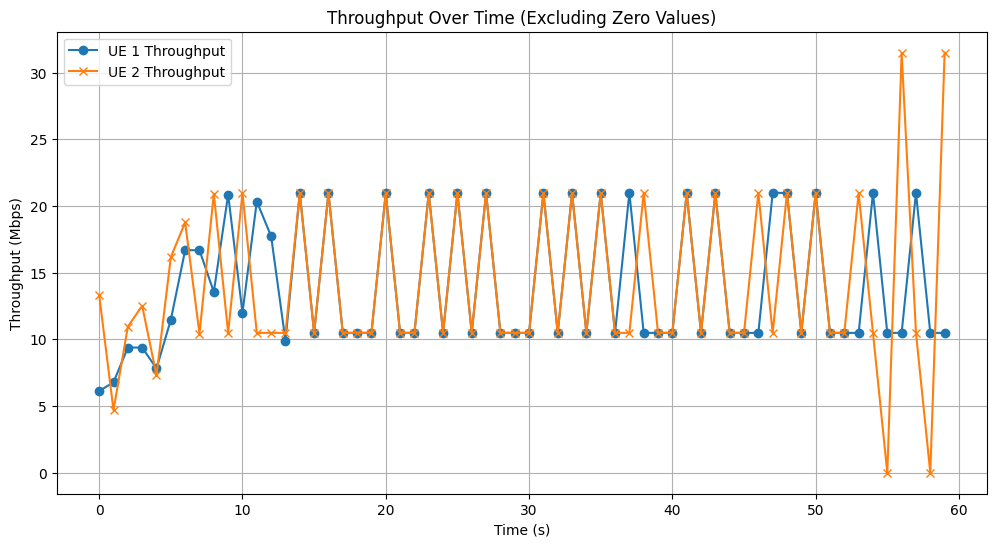

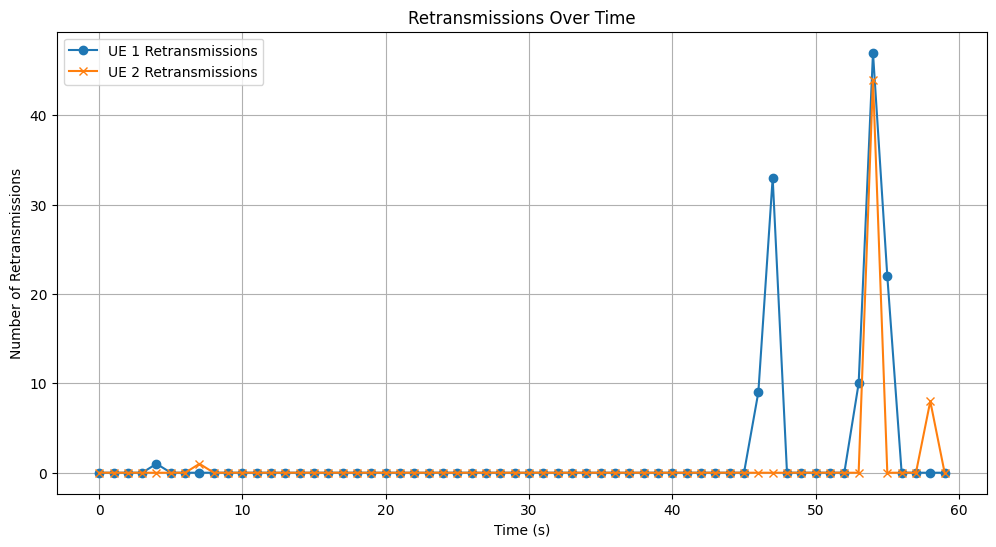

In [36]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with the paths to your actual iperf JSON result files
file1 = 'cubic_ecn_none-result-ue1.json'
file2 = 'cubic_ecn_none-result-ue2.json'

def load_iperf_data(filename):
    """Load iperf JSON data from a file and return a pandas DataFrame."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Initialize lists to store the extracted data
    intervals = data['intervals']
    start_times = []
    end_times = []
    durations = []
    throughputs = []
    retransmissions = []
    
    # Iterate over each interval in the data
    for interval in intervals:
        sum_data = interval['sum']
        start_times.append(sum_data['start'])
        end_times.append(sum_data['end'])
        durations.append(sum_data['seconds'])
        # Convert throughput from bits per second to megabits per second
        throughput_mbps = sum_data['bits_per_second'] / 1_000_000  # Divide by 1,000,000
        throughputs.append(throughput_mbps)
        retransmissions.append(sum_data.get('retransmits', 0))  # Retransmits might not be present in UDP tests
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Duration': durations,
        'Throughput (Mbps)': throughputs,
        'Retransmissions': retransmissions
    })
    
    return df

def filter_zero_throughput(df):
    """Filter out data points where throughput is zero."""
    return df[df['Throughput (Mbps)'] != 0].reset_index(drop=True)

# Load data from both files
df1 = load_iperf_data(file1)
df2 = load_iperf_data(file2)

# Filter out zero throughput data points for plotting throughput
# df1_nonzero = filter_zero_throughput(df1)
# df2_nonzero = filter_zero_throughput(df2)

# Calculate overall throughput and average retransmissions for each dataset
overall_throughput1 = df1['Throughput (Mbps)'].mean()
average_retransmits1 = df1['Retransmissions'].mean()

overall_throughput2 = df2['Throughput (Mbps)'].mean()
average_retransmits2 = df2['Retransmissions'].mean()

print(f"Dataset 1 - Overall Throughput: {overall_throughput1:.2f} Mbps")
print(f"Dataset 1 - Average Retransmissions: {average_retransmits1:.2f}")

print(f"\nDataset 2 - Overall Throughput: {overall_throughput2:.2f} Mbps")
print(f"Dataset 2 - Average Retransmissions: {average_retransmits2:.2f}")

# Plotting the throughputs over time (excluding zero throughput data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Throughput (Mbps)'], label='UE 1 Throughput', marker='o')
plt.plot(df2['Start Time'], df2['Throughput (Mbps)'], label='UE 2 Throughput', marker='x')
plt.title('Throughput Over Time (Excluding Zero Values)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the retransmissions over time (include all data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Retransmissions'], label='UE 1 Retransmissions', marker='o')
plt.plot(df2['Start Time'], df2['Retransmissions'], label='UE 2 Retransmissions', marker='x')
plt.title('Retransmissions Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Retransmissions')
plt.legend()
plt.grid(True)
plt.show()


COMMENT: the cwnd calculation is not showing the expected result. 

In [37]:

name_tx0="cubic_ecn_none"


# the csv files generated is of the following format
# timestamp, fd, cwnd, srtt

file_out_tx0_csv = name_tx0+"-ss.csv"

for ue_id in range(1, 3):
    print("Running to generate csv files " + name_tx0)

    ss_tx0_script_processing="""

    f_1={types}; 
    ue_id={ue_id};
    rm -f ${{f_1}}-ss-${{ue_id}}.csv;
    cat ${{f_1}}-ss-${{ue_id}}.txt | sed -e ":a; /<->$/ {{ N; s/<->\\n//; ba; }}"  | grep "iperf3" | grep -v "SYN-SENT"> ${{f_1}}-ss-processed-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | awk '{{print $1}}' > ts-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bcwnd:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' ' > cwnd-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\brtt:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' '  | cut -d '/' -f 1   > srtt-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bfd=.*?(\s|$)' | awk -F '[=,]' '{{print $2}}' | tr -d ')' | tr -d ' '   > fd-${{f_1}}-${{ue_id}}.txt;
    paste ts-${{f_1}}-${{ue_id}}.txt fd-${{f_1}}-${{ue_id}}.txt cwnd-${{f_1}}-${{ue_id}}.txt srtt-${{f_1}}-${{ue_id}}.txt -d ',' > ${{f_1}}-ss-${{ue_id}}.csv;""".format(types=name_tx0, ue_id="ue"+str(ue_id))

    tx.run(ss_tx0_script_processing)

tx.get("cubic_ecn_none"+"-ss-ue1.csv")
tx.get("cubic_ecn_none"+"-ss-ue2.csv")


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_6752\2911777773.py:12: SyntaxWarning: invalid escape sequence '\s'
  ss_tx0_script_processing="""


Running to generate csv files cubic_ecn_none
Running to generate csv files cubic_ecn_none


In [38]:
import itertools
import json
import pandas as pd

throughput_data = {}  # Initialize the dictionary
srtt_data = {}
cwnd_data= pd.DataFrame()
srtt_data_time= pd.DataFrame()

for ue_id in range(1, 3):
    name_tx0="cubic_ecn_none"
    ue_str = "ue"+str(ue_id)

    # Load the JSON output file into a Python object
    with open(f"{name_tx0}-result-{ue_str}.json") as f:
        iperf3_data = json.load(f)

    throughput_data[name_tx0+ue_str] = iperf3_data['end']['sum_received']['bits_per_second'] / (1000000 * 1)  # to convert Mbit

    # Average SRTT for Each Flow
    columns = ['timestamp', 'flow ID', 'cwnd', 'srtt']
    df_f1 = pd.read_csv(f"{name_tx0}-ss-{ue_str}.csv", names=columns)
    
    # Filter out rows with flow ID = 4, they are for the control flows
    df_f1 = df_f1[df_f1['flow ID'] != 4].reset_index(drop=True)

    average_RTT_f1 = df_f1['srtt'].mean()
    
    cwnd_data[name_tx0+ue_str] = df_f1['cwnd']
    srtt_data[name_tx0+ue_str] = average_RTT_f1
    srtt_data_time[name_tx0+ue_str] = df_f1['srtt']

# Save throughput_data to a JSON file
with open('throughput_data.json', 'w') as f:
    json.dump(throughput_data, f)

# Save srtt_data to a JSON file
with open('srtt_data.json', 'w') as f:
    json.dump(srtt_data, f)

cwnd_data.to_csv("consolidated_cwnd_data.csv", index=False)
srtt_data_time.to_csv("time_srtt.csv", index=False)

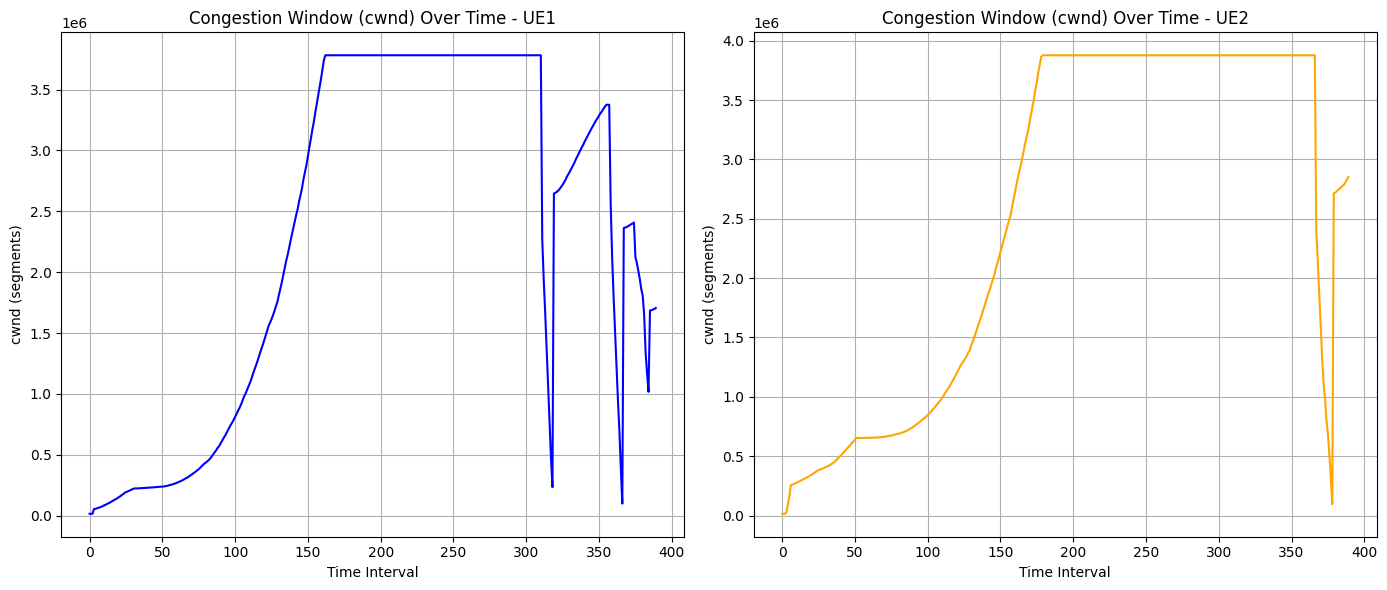

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# btl_limit_noecn=int(1000*btl_capacity*base_rtt*n_bdp /8)

# print("btl limit no ecn: ", btl_limit_noecn)

# Specify the filename
filename = 'consolidated_cwnd_data.csv'  # Replace with your actual filename

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)

# Extract data for each UE
ue1_data = df['cubic_ecn_noneue1']
ue2_data = df['cubic_ecn_noneue2']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for UE1
axes[0].plot(ue1_data*1448, marker='', color='blue')
axes[0].set_title('Congestion Window (cwnd) Over Time - UE1')
axes[0].set_xlabel('Time Interval')
axes[0].set_ylabel('cwnd (segments)')
# axes[0].axhline(y=btl_limit_noecn, color='b', linestyle='--', label=f'Buffer Size')
axes[0].grid(True)

# Plot for UE2
axes[1].plot(ue2_data*1448, marker='', color='orange')
axes[1].set_title('Congestion Window (cwnd) Over Time - UE2')
axes[1].set_xlabel('Time Interval')
axes[1].set_ylabel('cwnd (segments)')
# axes[1].axhline(y=btl_limit_noecn, color='b', linestyle='--', label=f'Buffer Size')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [42]:
router.get("monitor.log")

In [43]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual filename
filename = 'monitor.log'

def parse_qdisc_data(filename):
    """Parse qdisc data from a file and return a DataFrame."""
    timestamps = []
    sent_bytes = []
    sent_packets = []
    dropped_packets = []
    overlimits = []
    backlog_bytes = []
    backlog_packets = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            # Extract timestamp
            match_time = re.match(r'^(\d+\.\d+)', line)
            if match_time:
                timestamp = float(match_time.group(1))
                timestamps.append(timestamp)
            else:
                continue  # Skip line if timestamp not found

            # Extract bfifo qdisc statistics
            # Assuming 'qdisc bfifo' appears after 'qdisc htb' in the line
            bfifo_data = line.split('qdisc bfifo')[1]

            # Extract Sent bytes and packets
            match_sent = re.search(r'Sent\s+(\d+)\s+bytes\s+(\d+)\s+pkt', bfifo_data)
            if match_sent:
                sent_bytes.append(int(match_sent.group(1)))
                sent_packets.append(int(match_sent.group(2)))
            else:
                sent_bytes.append(None)
                sent_packets.append(None)

            # Extract dropped packets
            match_dropped = re.search(r'dropped\s+(\d+)', bfifo_data)
            if match_dropped:
                dropped_packets.append(int(match_dropped.group(1)))
            else:
                dropped_packets.append(None)

            # Extract overlimits
            match_overlimits = re.search(r'overlimits\s+(\d+)', bfifo_data)
            if match_overlimits:
                overlimits.append(int(match_overlimits.group(1)))
            else:
                overlimits.append(None)

            # Extract backlog bytes and packets
            match_backlog = re.search(r'backlog\s+(\d+)b\s+(\d+)p', bfifo_data)
            if match_backlog:
                backlog_bytes.append(int(match_backlog.group(1)))
                backlog_packets.append(int(match_backlog.group(2)))
            else:
                backlog_bytes.append(None)
                backlog_packets.append(None)

    # Create a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Sent Bytes': sent_bytes,
        'Sent Packets': sent_packets,
        'Dropped Packets': dropped_packets,
        'Overlimits': overlimits,
        'Backlog Bytes': backlog_bytes,
        'Backlog Packets': backlog_packets
    })

    # Convert timestamps to relative time (seconds since start)
    df['Relative Time'] = df['Timestamp'] - df['Timestamp'].iloc[0]

    return df

def plot_queue_length(df):
    """Plot queue length (backlog) over time."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Backlog Bytes'], marker='o')
    plt.title('Queue Length (Backlog) Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Backlog (bytes)')
    plt.grid(True)
    plt.show()

def plot_packet_drop_rate(df):
    """Plot packet drop rate over time."""
    # Calculate the difference in dropped packets between measurements
    df['Dropped Packets Diff'] = df['Dropped Packets'].diff().fillna(0)

    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Dropped Packets Diff'], marker='x', color='red')
    plt.title('Packet Drop Rate Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Dropped Packets per Interval')
    plt.grid(True)
    plt.show()

def analyze_backlog(df):
    """Analyze backlog and determine if there is a backlog."""
    max_backlog = df['Backlog Bytes'].max()
    if max_backlog > 0:
        print(f"There is a backlog. Maximum backlog is {max_backlog} bytes.")
    else:
        print("There is no backlog. The queue is empty throughout the measurements.")

# Main execution
df = parse_qdisc_data(filename)

# Plot queue length
plot_queue_length(df)

# Plot packet drop rate
plot_packet_drop_rate(df)

# Analyze backlog
analyze_backlog(df)


IndexError: list index out of range